# Clustering Neighbourhoods in Toronto

# Introduction
Everybody has a dream place where they want to live. But as housing prices have skyrockeded during the past years, the area where one ideally would want to live, may not be in range when it comes to affordability. In this project, I try to mitigate some of that issue by providing a framework where a person who has seen their dream area but think it's too expensive, can see what other areas that are similar, but cheaper.


# Data
As data I use income data from St. Louis Fed (income data from St. Louis Fed (https://geofred.stlouisfed.org/map/?th=reds&cc=5&rc=false&im=fractile&sb&lng=-90.00&lat=39.98&zm=4&sl&sv&am=Average&at=Not%20Seasonally%20Adjusted,%20Annual,%20Dollars,%20no_period_desc&sti=1019&fq=Annual&rt=county&un=lin&dt=2019-01-01) and lat/long data from simplemaps.com (https://simplemaps.com/data/us-cities). I then use the lat/long data per city to retrieve the 50 most popular spots at that specific location via the Foursquare explore service.

For the purpose of this lab i limit i limit my selection to the west coast of the US (as defined by west of lat -117), with my favourite area set to seattle. I then focus on the top three cities in each region that has a population over 10k. I crudley proxy the cost of living with the median household income, and assume it's strongly correlated.


# Methodology section
- Initial library import
- Downloading, Cleaning and Merging of data
- Viewing Data
- Foursquare Initiation and Download
- Using TF-IDF to set data apart.
- Clustering Cities

### Initial library import

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

!pip install folium
import folium # map rendering library

!pip install yellowbrick
!pip install geocoder

     |████████████████████████████████| 94 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 271 kB 17.9 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 8.2 MB/s  eta 0:00:01


### Get and clean data
This will be used as a proxy for cost of living in an area

In [2]:
income = pd.read_html('https://github.com/19919/Coursera_Capstone/blob/master/medianHouseholdIncCommaSep.csv')[0]

In [3]:
income = income.iloc[:,2:]

Downloading state abbreviations

In [4]:
abbrevs = pd.read_html('https://www.ssa.gov/international/coc-docs/states.html')[0]

In [5]:
income['name'] = income.apply(lambda x: x.Region+', '+x.State, axis = 1)

Required to state that data  is from https://simplemaps.com/data/us-cities

In [6]:
!wget 'https://simplemaps.com/static/data/us-cities/1.73/basic/simplemaps_uscities_basicv1.73.zip'

--2021-02-24 18:58:23--  https://simplemaps.com/static/data/us-cities/1.73/basic/simplemaps_uscities_basicv1.73.zip
Resolving simplemaps.com (simplemaps.com)... 104.26.13.95, 172.67.71.113, 104.26.12.95, ...
Connecting to simplemaps.com (simplemaps.com)|104.26.13.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3855871 (3.7M) [application/zip]
Saving to: ‘simplemaps_uscities_basicv1.73.zip’

simplemaps_uscities 100%[===================>]   3.68M  19.7MB/s    in 0.2s    

2021-02-24 18:58:24 (19.7 MB/s) - ‘simplemaps_uscities_basicv1.73.zip’ saved [3855871/3855871]



Unzipping the downloaded data

In [7]:
!unzip simplemaps_uscities_basicv1.73.zip

Archive:  simplemaps_uscities_basicv1.73.zip
  inflating: license.txt             
  inflating: uscities.csv            
  inflating: uscities.xlsx           


Importing details

In [8]:
details = pd.read_csv('uscities.csv')

limiting to cities in the west with over 10k ppl

In [9]:
cities = pd.merge(income, details, left_on = 'RegionCode', right_on = 'county_fips')
cities = cities[(cities.lng < -117) & (cities.lng > -125)]
cities = cities[cities.population > 10000]
grouped = cities.groupby('Region')

In [13]:
topCities = []
for citi in grouped.groups:
    topCities.append([x for x in grouped.get_group(citi).sort_values('population', ascending = False).head(3).index.values])

In [14]:
topCities = cities.loc[[item for sublist in topCities for item in sublist]]
topCities = topCities.reset_index(drop = True)

## Viewing Data
### Below we can see the initial dataframe

In [67]:
topCities.head(5)

,RegionCode,MedianIncome,State,Region,name,city,city_ascii,state_id,state_name,county_fips,...,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,53001,47739,WA,Adams County,"Adams County, WA",Othello,Othello,WA,Washington,53001,...,-119.1652,12761,814,polygon,False,True,America/Los_Angeles,3,99344,1840019862
1,6001,105354,CA,Alameda County,"Alameda County, CA",Oakland,Oakland,CA,California,6001,...,-122.2165,433031,2991,polygon,False,True,America/Los_Angeles,2,94621 94705 94704 94611 94610 94613 94619 9461...,1840020296
2,6001,105354,CA,Alameda County,"Alameda County, CA",Fremont,Fremont,CA,California,6001,...,-121.9852,241110,1201,polygon,False,True,America/Los_Angeles,2,94536 94538 94539 94555 94537,1840020292
3,6001,105354,CA,Alameda County,"Alameda County, CA",Hayward,Hayward,CA,California,6001,...,-122.0772,159203,1349,polygon,False,True,America/Los_Angeles,2,94541 94542 94545 94544 94540 94543 94557,1840020293
4,53005,68129,WA,Benton County,"Benton County, WA",Kennewick,Kennewick,WA,Washington,53005,...,-119.1732,240735,1186,polygon,False,True,America/Los_Angeles,2,99337 99336 99338,1840018481


### Create a map with the cities superimposed on top.


In [17]:
# create map of the selected cities
map_topCities = folium.Map(location=[40, -117], zoom_start=5)

# add markers to map
for lat, lng, size, city in zip(topCities['lat'], topCities['lng'], topCities['population'], topCities['city']):
    label = folium.Popup(city, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size/300000,
        popup=city,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_topCities)  
    
map_topCities

#### Define Foursquare Credentials and Version


In [70]:
CLIENT_ID = 'ABC' # your Foursquare ID
CLIENT_SECRET = 'ABC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 400 # A default Foursquare API limit value


print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ABC
CLIENT_SECRET:ABC


In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity=1'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Downloading the data from foursqare

In [20]:
us_venues = getNearbyVenues(names=topCities['city'],
                                   latitudes=topCities['lat'],
                                   longitudes=topCities['lng'])


Othello
Oakland
Fremont
Hayward
Kennewick
Corvallis
Richland
Chico
Oroville
Magalia
Carson City
Wenatchee
Fallon
Lake Oswego
Oregon City
West Linn
Port Angeles
Sequim
Vancouver
Camas
Orchards
Astoria
St. Helens
Concord
Antioch
Richmond
Coos Bay
Longview
Kelso
Prineville
Brookings
Crescent City
Bend
Redmond
Roseburg
East Wenatchee
Gardnerville Ranchos
El Dorado Hills
Placerville
South Lake Tahoe
Pasco
Fresno
Clovis
Reedley
Moses Lake
Aberdeen
Hood River
Eureka
Arcata
McKinleyville
Oak Harbor
Camano
Medford
Ashland
Central Point
Grants Pass
Bakersfield
Delano
Oildale
Seattle
Bellevue
Kent
Hanford
Lemoore
Corcoran
Bremerton
Bainbridge Island
Silverdale
Ellensburg
Klamath Falls
Altamont
Lakeport
Clearlake
Eugene
Springfield
Cottage Grove
Susanville
Centralia
Lincoln City
Newport
Albany
Lebanon
Sweet Home
Los Angeles
Long Beach
Lancaster
Fernley
Madera
Chowchilla
San Rafael
Novato
Mill Valley
Salem
Keizer
Woodburn
Shelton
Ukiah
Fort Bragg
Merced
Los Banos
Atwater
Salinas
Seaside
Monterey
Po

## Initiate data for clustering


In [21]:
# one hot encoding
us_onehot = pd.get_dummies(us_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
us_onehot['city'] = us_venues['Neighborhood'] 

# move city column to the first column
fixed_columns = [us_onehot.columns[-1]] + list(us_onehot.columns[:-1])
us_onehot = us_onehot[fixed_columns]

us_onehot.head()

,city,ATM,Accessories Store,Adult Boutique,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,...,Water Park,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Othello,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Othello,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Othello,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Othello,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Othello,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.


In [22]:
us_onehot.shape

(6037, 374)

## TF-IDF
In the above matrix, we see the resulting data frame with the different venues counted. However, since these are cities in the same country, they are bound to look fairly similar (yes, there are differences, but let's be honnest here...). To really get the nuances of the neighborhoods that we love, I try to normalize the data a bit further, by using tf-idf. The method is usually used for text mining, however, the theory still applies to this as well, I believe. 

In [23]:
temp = us_onehot.set_index('city')

In [24]:
tf = temp.groupby('city').mean()
tf

,ATM,Accessories Store,Adult Boutique,Airport,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,...,Water Park,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
city,,,,,,,,,,,,,,,,,,,,,
Aberdeen,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
Albany,0.0,0.0,0.0,0.0,0.037037,0.0,0.037037,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
Altamont,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.076923,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
American Canyon,0.0,0.0,0.0,0.0,0.000000,0.0,0.020000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.02,0.0,0.0
Anacortes,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Sacramento,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
Woodburn,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0
Woodland,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.032258,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0


In [25]:
idf = np.log(len(tf.index) / (tf > 0).sum())

#### As can be seen from the below, the method weighs items that there are few of higher, and common things lower.

In [49]:
idf

ATM                  1.709521
Accessories Store    3.960813
Adult Boutique       5.347108
Airport              5.347108
Airport Service      4.653960
                       ...   
Wine Shop            3.267666
Winery               4.653960
Wings Joint          2.782158
Women's Store        2.708050
Yoga Studio          2.949212
Length: 373, dtype: float64

In [26]:
us_grouped = (tf*idf).reset_index()

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['city']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['city'] = us_grouped['city']

for ind in np.arange(us_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(us_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,city,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aberdeen,Historic Site,Butcher,History Museum,Fast Food Restaurant,Music Venue,Thrift / Vintage Store,Toy / Game Store,Men's Store,Electronics Store,Farmers Market
1,Albany,Airport Service,Bus Stop,Train Station,Shopping Mall,Gas Station,Seafood Restaurant,Hardware Store,Convenience Store,Home Service,Sporting Goods Shop
2,Altamont,Construction & Landscaping,Andhra Restaurant,Supplement Shop,Home Service,Sporting Goods Shop,Salon / Barbershop,Hotel,Pizza Place,Fast Food Restaurant,Grocery Store
3,American Canyon,Pastry Shop,Food Stand,Baseball Field,Gym Pool,Farm,Casino,Tennis Court,Lake,Shopping Plaza,Garden Center
4,Anacortes,Shop & Service,Dog Run,Trail,Yoga Studio,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Eye Doctor,Fabric Shop


<a id='item4'></a>


### Clustering Cities


In [29]:
us_grouped_clustering = us_grouped.drop('city', 1)

In [30]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Preprocessing for better clustering results

In [31]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(us_grouped.drop('city', 1))

Clustering using SpectralClustering from sk Learn

In [55]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=14, assign_labels="discretize", random_state=0).fit(X)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


#### Checking how many cities in each group

In [56]:
unique, counts = numpy.unique(clustering.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 6,
 1: 45,
 2: 2,
 3: 2,
 4: 2,
 5: 3,
 6: 4,
 7: 4,
 8: 3,
 9: 44,
 10: 6,
 11: 67,
 12: 21,
 13: 1}

In [58]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', clustering.labels_)

us_merged = topCities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
us_merged = us_merged.join(neighbourhoods_venues_sorted.set_index('city'), on='city')

us_merged.head() # check the last columns!

,RegionCode,MedianIncome,State,Region,name,city,city_ascii,state_id,state_name,county_fips,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,53001,47739,WA,Adams County,"Adams County, WA",Othello,Othello,WA,Washington,53001,...,Electronics Store,Movie Theater,Baseball Field,Construction & Landscaping,ATM,Gym / Fitness Center,Mexican Restaurant,Hotel,Fast Food Restaurant,Pizza Place
1,6001,105354,CA,Alameda County,"Alameda County, CA",Oakland,Oakland,CA,California,6001,...,Market,Liquor Store,Filipino Restaurant,Latin American Restaurant,Music Store,Park,Garden Center,Food & Drink Shop,Intersection,Playground
2,6001,105354,CA,Alameda County,"Alameda County, CA",Fremont,Fremont,CA,California,6001,...,Vietnamese Restaurant,Rental Car Location,Bubble Tea Shop,Hunan Restaurant,Shanghai Restaurant,Falafel Restaurant,Taiwanese Restaurant,Filipino Restaurant,Cajun / Creole Restaurant,Auto Garage
3,6001,105354,CA,Alameda County,"Alameda County, CA",Hayward,Hayward,CA,California,6001,...,Library,Other Great Outdoors,Doctor's Office,Park,Business Service,Supermarket,Department Store,Chinese Restaurant,Food Truck,Home Service
4,53005,68129,WA,Benton County,"Benton County, WA",Kennewick,Kennewick,WA,Washington,53005,...,Motorcycle Shop,Supermarket,Convenience Store,Gas Station,Park,Mexican Restaurant,Farmers Market,Ethiopian Restaurant,Event Service,Eye Doctor


In [59]:
us = us_merged.dropna()

# Results

In [61]:
# create map
map_clusters = folium.Map(location=[40, -117], zoom_start=5)

# set color scheme for the clusters
x = np.arange(14)
ys = [i + x + (i*x)**2 for i in range(14)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(us['lat'], us['lng'], us['city'], us['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


Checking which cluster Seattle is in

In [62]:
seattleCluster = us[us.city == 'Seattle']['Cluster Labels'].values[0]

In [78]:
us[us.city == 'Seattle'].T

,59
RegionCode,53033
MedianIncome,100308
State,WA
Region,King County
name,"King County, WA"
city,Seattle
city_ascii,Seattle
state_id,WA
state_name,Washington
county_fips,53033


#### What can be seen below seems to be a common residential area. Whereas we could see mostly restaurants before, we now see a typical residential area. 

In [71]:
clFrame = us_merged.loc[us_merged['Cluster Labels'] == seattleCluster, us_merged.columns[[1] + list(range(5, us_merged.shape[1]))]]
clFrame.head()

,MedianIncome,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,105354,Oakland,Oakland,CA,California,6001,Alameda,37.7903,-122.2165,433031,...,Market,Liquor Store,Filipino Restaurant,Latin American Restaurant,Music Store,Park,Garden Center,Food & Drink Shop,Intersection,Playground
4,68129,Kennewick,Kennewick,WA,Washington,53005,Benton,46.1978,-119.1732,240735,...,Motorcycle Shop,Supermarket,Convenience Store,Gas Station,Park,Mexican Restaurant,Farmers Market,Ethiopian Restaurant,Event Service,Eye Doctor
5,64512,Corvallis,Corvallis,OR,Oregon,41003,Benton,44.5697,-123.2780,67467,...,Vegetarian / Vegan Restaurant,College Bookstore,Pub,College Baseball Diamond,Noodle House,Comic Shop,Nightclub,Hot Dog Joint,Coffee Shop,Wine Shop
21,55117,Astoria,Astoria,OR,Oregon,41007,Clatsop,46.1856,-123.8053,14916,...,Pier,Beer Garden,Marijuana Dispensary,Home Service,Brewery,Grocery Store,Bar,Gas Station,Hotel,Chinese Restaurant
24,103354,Antioch,Antioch,CA,California,6013,Contra Costa,37.9789,-121.7958,302419,...,Sports Bar,Dessert Shop,Optical Shop,Business Service,Pharmacy,Mobile Phone Shop,Restaurant,Gym / Fitness Center,Ice Cream Shop,Chinese Restaurant


In [73]:
clFrame['1st Most Common Venue'].value_counts().head(10)

Beach             2
Auto Garage       2
Discount Store    2
Market            2
Big Box Store     2
Brewery           2
Pier              1
Scenic Lookout    1
Burrito Place     1
Dog Run           1
Name: 1st Most Common Venue, dtype: int64

Checking the income distribution in the cluster

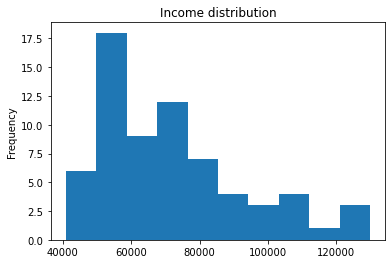

In [81]:
clFrame.MedianIncome.plot(kind = 'hist', title = 'Income distribution')

We are now ready to investigate which other cities that are in the Seattle cluster, and then we sort the results on the Median Income.

In [66]:
us[us['Cluster Labels'] == seattleCluster][['city', 'Cluster Labels', 'MedianIncome', 'state_name', 'population']].sort_values('MedianIncome').head(10)

,city,Cluster Labels,MedianIncome,state_name,population
202,Pullman,11.0,40858,Washington,34506
31,Crescent City,11.0,43919,California,16849
30,Brookings,11.0,46747,Oregon,11162
49,McKinleyville,11.0,47446,California,17208
47,Eureka,11.0,47446,California,44236
70,Altamont,11.0,49412,Oregon,19341
57,Delano,11.0,51116,California,54917
192,The Dalles,11.0,52575,Oregon,20442
205,Sunnyside,11.0,52764,Washington,18352
203,Yakima,11.0,52764,Washington,133191


# Discussion section
As can be seen above, the recommendation for anyone wanting to live in Seattle could consider these similar cities instead. Of course, this report only looks at the venues and the service offerings in the cities, and does not care about scenery or any environmental factors. Another limiting factor in this analysis is the Foursquare limitation of how many venues that can be retrieved from the API for the same place. Furthermore, it would be interesting to look at environmental variables, like distance to bodies of water, mountains and similar to see if this would yield different results. Unfortunately, this has been deemed out of scope for this report.

I used the Spectral Clustering method to cluster the cities to get a more homogenous distribution of results in each cluster, as KMeans produced too little variability.

# Conclusion
In conclustion, I believe there is some truth to the findings. Looking at perhaps *Eureka* from the above select cities, it may be a viable alternative to Seattle as it is very close to the Pacific Ocean as well. 